#### Time series task for prospective DTSE AIS data scientists

You have the following data available: 

- Macroeconomic Data for 1959Q1 - 2009Q3
- realgdp: Real gross domestic product (Bil. of chained 2005 US dollars, seasonally adjusted annual rate)
- pop: End of the quarter total population, all ages (in millions)
- unemp: Seasonally adjusted unemployment rate (in %)
- infl: Inflation rate (in %)

In [1]:
import pandas as pd

data = pd.read_csv('DTSE_AIS_unemployment_task_data.csv')
data.head()

,Period,realgdp,pop,unemp,infl
0,1959-01-01,2710.349,177.146,5.8,0.00
1,1959-04-01,2778.801,177.830,5.1,2.34
2,1959-07-01,2775.488,178.657,5.3,2.74
3,1959-10-01,2785.204,179.386,5.6,0.27
4,1960-01-01,2847.699,180.007,5.2,2.31


##### Objectives

Using  only the data provided:

1) Forecast the quarterly unemployment rate until and including Q4 2013. The other available variables may or may not be used for the purposes of the forecast - that's up to you

2) Predict how many people will be unemployed in 2013. For the purposes of this subtask, 65% of the population is considered to be in the labor force at all times

- Describe and explain any exploratory steps you are taking
- Put the biggest emphasis on the modeling part and explain your thought process and decisions taken
- During modeling, you should try and compare at least two different models and try different parameters for the models of your choice, if applicable 
- Explain your model selection process and how you arrived at your final model choice
- Summarize your final forecasts verbally, as if you would explain your results to a non-technical colleague

Use this Jupyter notebook to show your work. After you're done, send either the .ipynb file *and* the HTML export, or alternatively a link to your personal repository. 

### Libraries import section

In [2]:
import plotly.graph_objects as go
import plotly.subplots as sp
import statsmodels.api as sm
import plotly.express as px
import numpy as np
import warnings


from sklearn.linear_model import LinearRegression
from scipy.stats.mstats import winsorize
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from utils import adf_test, make_stationary, calculate_dof, granger_causality_matrix
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

### I. Exploratory Data Analysis

Firstly, we will begin with exploring our dataset, the variables inside, the missing values, and the corresponding plots for each variable in order to gain more insights about how the data looks.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Period   203 non-null    object 
 1   realgdp  203 non-null    float64
 2   pop      203 non-null    float64
 3   unemp    202 non-null    float64
 4   infl     203 non-null    float64
dtypes: float64(4), object(1)
memory usage: 8.1+ KB


We will convert the Period variable to a datetime object and set it as the index of the dataframe

In [4]:
data['Period'] = pd.to_datetime(data['Period'])
data.set_index('Period', inplace=True)
data.head()

,realgdp,pop,unemp,infl
Period,,,,
1959-01-01,2710.349,177.146,5.8,0.00
1959-04-01,2778.801,177.830,5.1,2.34
1959-07-01,2775.488,178.657,5.3,2.74
1959-10-01,2785.204,179.386,5.6,0.27
1960-01-01,2847.699,180.007,5.2,2.31


a) The missingness in the data

In [5]:
missing_df = data.isna().sum()/len(data)*100
missing_df

realgdp    0.000000
pop        0.000000
unemp      0.492611
infl       0.000000
dtype: float64

There is just a small portion of missing data in the dataset, more precisely for the unemp variable (roughly 0.49%). So, in order to fill this one gap, I can use a simple interpolation method to fill the missing data. Given the fact that the dataset is perfectly time-indexed, based on the appearance of the quarterly intervals, a linear interpolation will be suitable rather than using the time interpolation method in this case 

In [6]:
data['unemp'] = data['unemp'].interpolate(method='linear')

b) VISualize our variables inside the dataset to gain more insights

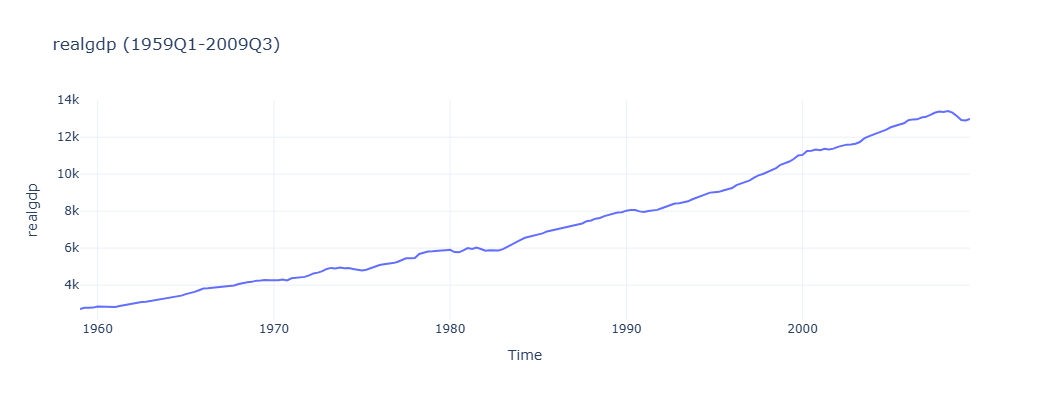

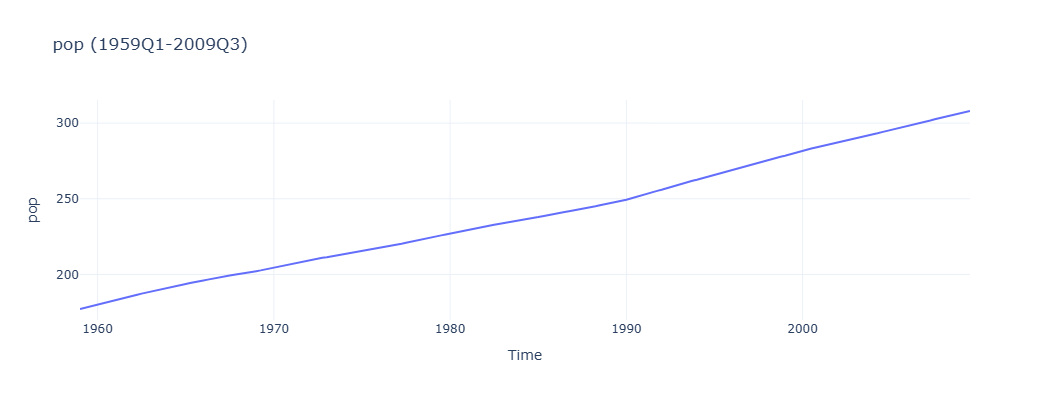

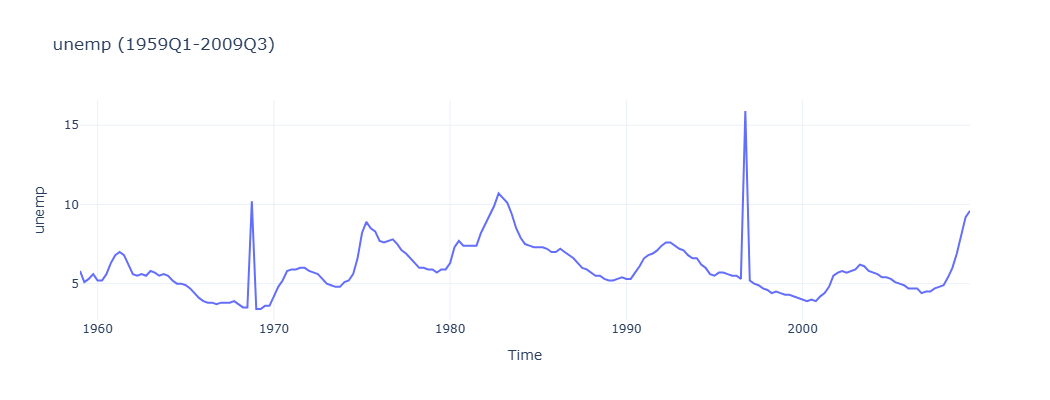

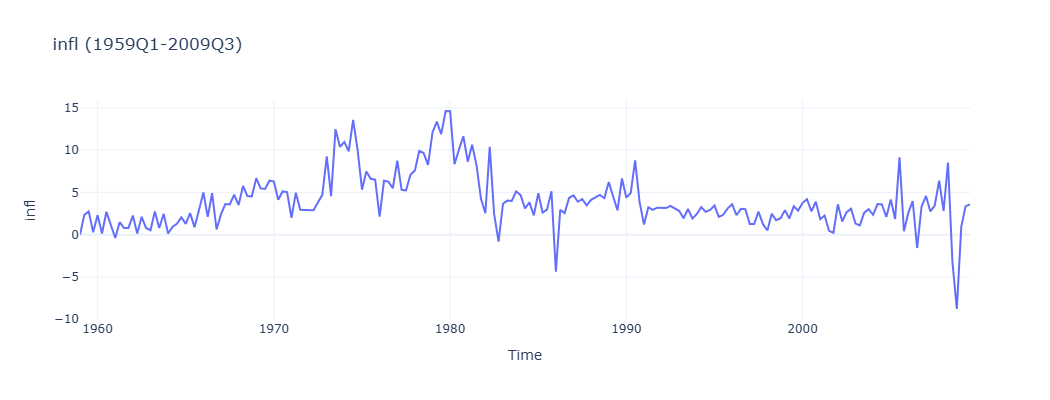

In [7]:
for col in data.columns:
    fig = px.line(data, x=data.index, y=col, 
                  title=f'{col} (1959Q1-2009Q3)')
    fig.update_layout(
        xaxis_title='Time', 
        yaxis_title=col, 
        template='plotly_white',
        width=1200,
        height=400
    )
    fig.show()

Based on the plots above, we can say that:
- realgdp is obviously displaying an upward trend, reflecting economic growth over time with noticeable dips during some important time events (recessions);
- the population growth seems to be linear and steady over time, so it's easy to conclude its ongoing trend;
- unemployment rate is one of the most fluctuating series and is sensible to economic fluctuations (may be linked to 1981-1982 recession) and the 2009 global financial crisis which led to mass layoffs;
- inflation rate, also highly volatile, sensible to economic events (1973 oil crisis, global instability)

c) Decomposing the series

I have chosen to go further with the additive decomposition based on the fact that in our dataset there are also negative values present (e.g. for inflation) and a multiplicative approach requires that all values should be positive

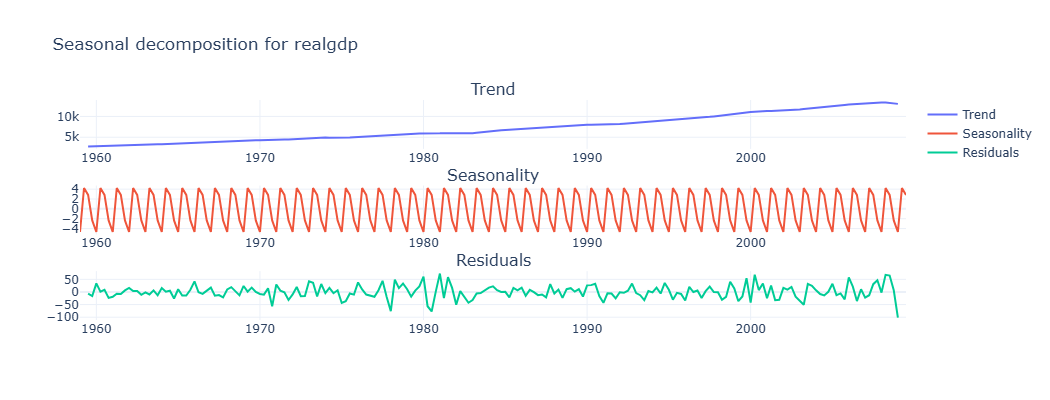

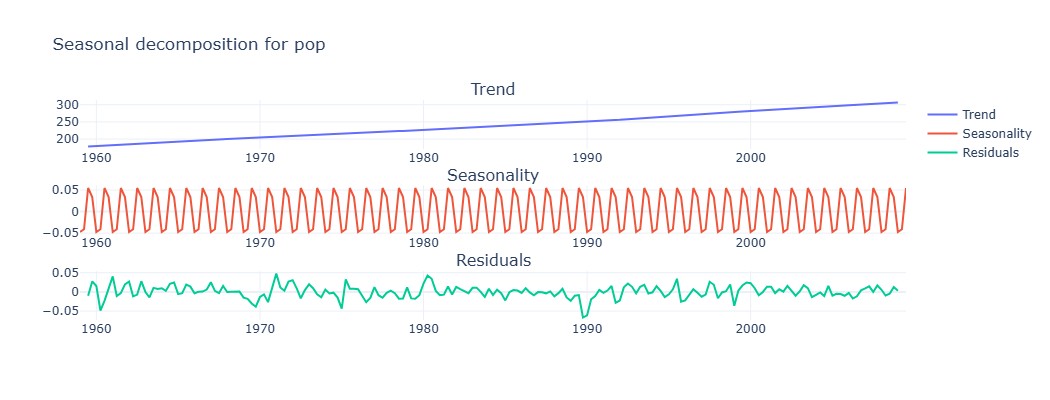

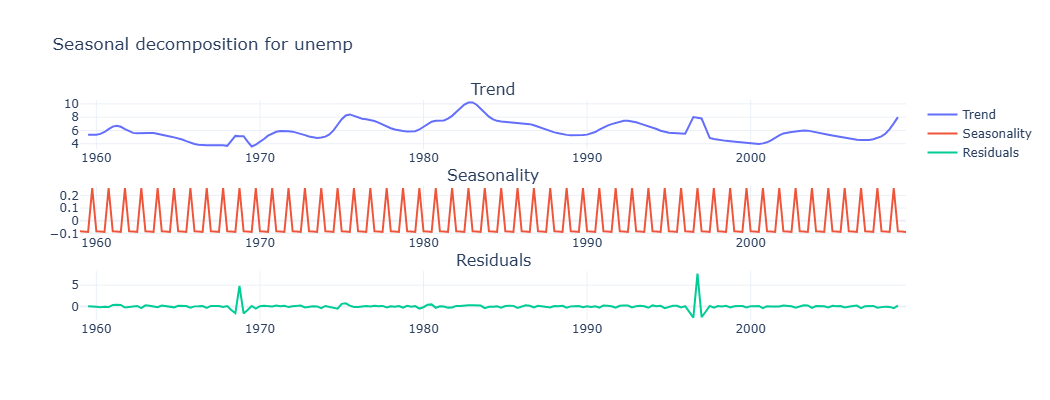

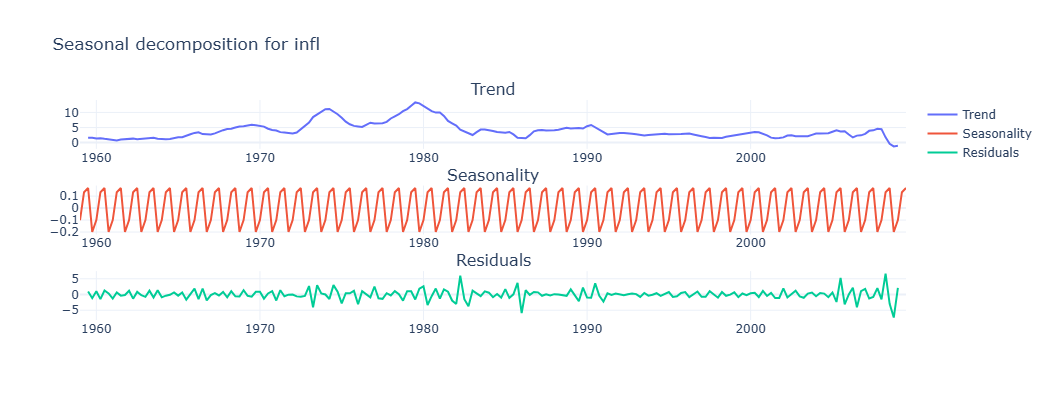

In [8]:
for col in data.columns:
    result = seasonal_decompose(data[col], model='additive', period=4)

    fig = sp.make_subplots(rows=3, cols=1, subplot_titles=['Trend', 'Seasonality', 'Residuals'])

    fig.add_trace(go.Scatter(x=data.index, y=result.trend, mode='lines', name='Trend'), row=1, col=1)
    fig.add_trace(go.Scatter(x=data.index, y=result.seasonal, mode='lines', name='Seasonality'), row=2, col=1)
    fig.add_trace(go.Scatter(x=data.index, y=result.resid, mode='lines', name='Residuals'), row=3, col=1)

    fig.update_layout(height=400, width=1200, title_text=f'Seasonal decomposition for {col}', template='plotly_white')
    fig.show()

Based on the decomposition of each variable we can conclude different things:
- realgdp trend reflects an upward trajectory which confirms consistent economic increase over the years, but with notable declines through historical events while its seasonality reveals regular quarterly patterns (it may be linked to cyclical production and consumption behaviors); the residuals remain stable in general but there is some evident variance during periods of instability;
- pop's trend is linear with minimal seasonal variation, reflecting continuous growth; the cumulative nature of pop variable leads to no seasonal patterns for pop var; the residuals are relatively stable with minor deviations (some slight unexpected variations)
- unemployment’s trend highlights significant peaks during economic crises, while its seasonal component suggests recurring employment patterns within a year; residuals display variability during economic downturns (labor market's sensitivity to sudden macroeconomic shifts)
- inflation’s trend displays sharp increases during historical economic shocks, with seasonal patterns likely tied to economic cycles; residuals are reflecting the influence of unpredictable factors on inflation (global events, political decisions or some other factors);

d) Studying the outliers in our data. Winsorization

Now I will study the existence of outliers in our data using box plot representation. Based on these plots, I will decide which variable to winsorize in order to maintain the integrity of the dataset

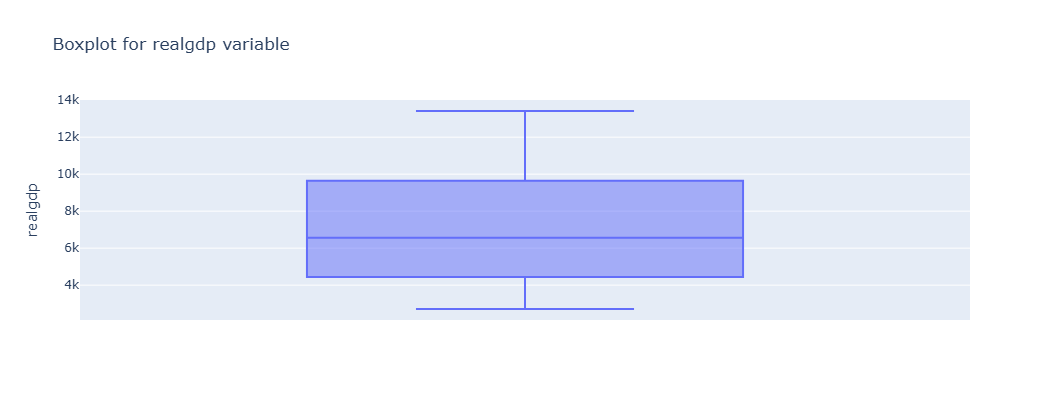

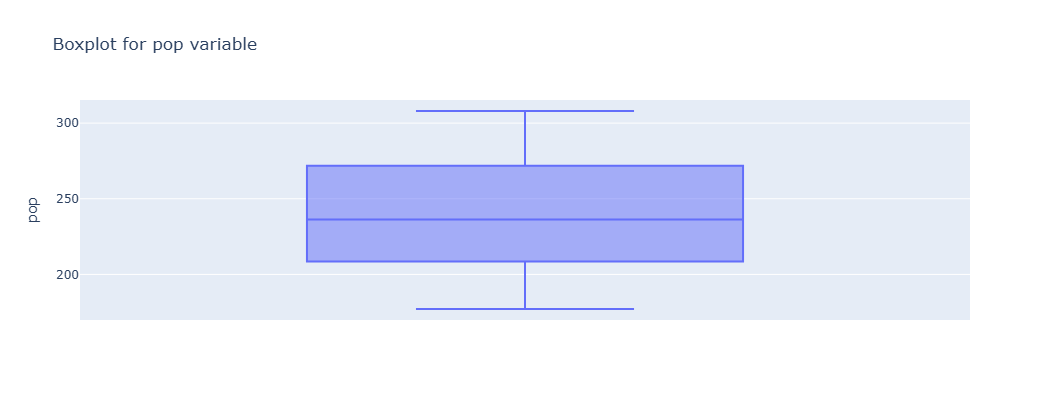

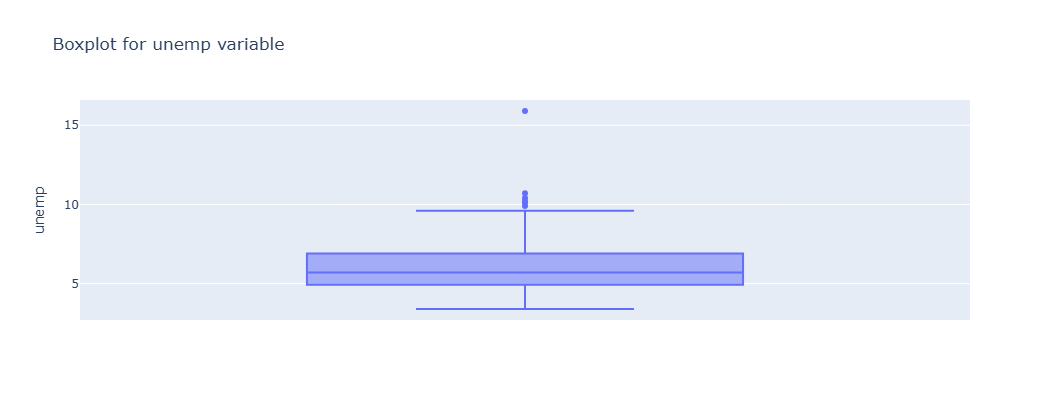

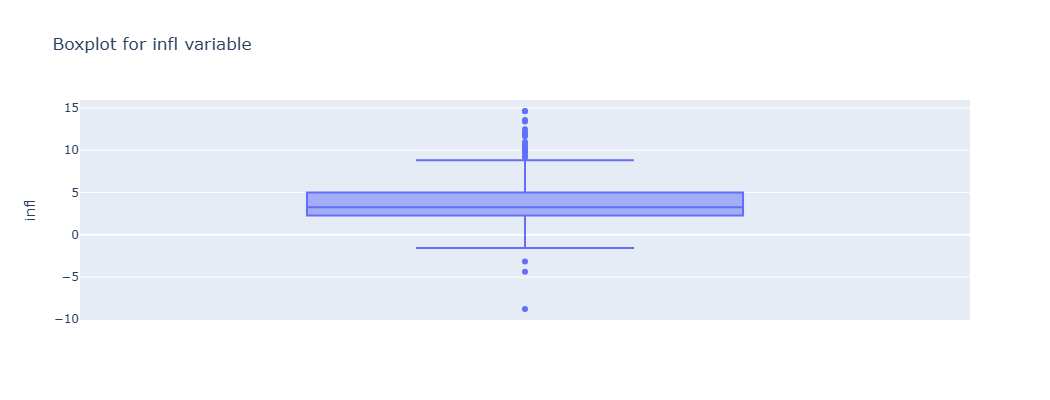

In [9]:
for var in data.columns:
    fig = px.box(data, y=var, title=f'Boxplot for {var} variable')
    fig.update_layout(width=600, height=400)
    fig.show()

As we can observe from the above plots, for the variables unemp and infl there are multiple outliers present. For the unemp variable, there are a few significant outliers above 10%, with one extreme point above 15%. As for the infl variable, the range is wide, with several values exceeding 10% and going below -5%. This is aligned with historical economic events (e.g., oil shocks, recessions, or deflationary periods). I will winsorize just the unemp variable (5% winsorization) and I will leave the infl variable as it is now.

In [10]:
data['unemp_wins'] = winsorize(data['unemp'], limits=[0.05, 0.05])

e) Studying the stationarity 

In this subsection we will employ the Augmented Dickey-Fuller test in order to find the stationarity of each variable within our dataset. We will do so on the raw variables that we have vailable

In [11]:
for column in data.columns:
    adf_test(data[column], column)

ADF test for realgdp:
ADF statistic: 1.7504627967647133
p-value: 0.9982455372335032
Critical values:
1%: -3.4652439354133255
5%: -2.8768752281673717
10%: -2.574944653739612
Stationary: False

ADF test for pop:
ADF statistic: 1.730646621830091
p-value: 0.998201073889376
Critical values:
1%: -3.465811691080702
5%: -2.877123351472649
10%: -2.5750770662586864
Stationary: False

ADF test for unemp:
ADF statistic: -3.086359013410627
p-value: 0.027579291063347017
Critical values:
1%: -3.463476079125
5%: -2.876102355
10%: -2.574532225
Stationary: True

ADF test for infl:
ADF statistic: -3.054514496257238
p-value: 0.030107620863485774
Critical values:
1%: -3.463476079125
5%: -2.876102355
10%: -2.574532225
Stationary: True

ADF test for unemp_wins:
ADF statistic: -2.4627491723568506
p-value: 0.12480287353208053
Critical values:
1%: -3.4633090972761744
5%: -2.876029332045744
10%: -2.5744932593252643
Stationary: False



For those variables which are not stationary, we will try to find the order of differentiation in order to transform them into stationary series.

In [12]:
for col in ['realgdp', 'pop', 'unemp_wins']:
    data[col + "_diff"] = make_stationary(data[col], max_diff=5)

Order 0: ADF statistic=1.7504627967647133, p-value=0.9982455372335032
Order 1: ADF statistic=-6.305695561658103, p-value=3.327882187668259e-08
Series is stationary after 1 diffs
Order 0: ADF statistic=1.730646621830091, p-value=0.998201073889376
Order 1: ADF statistic=-1.615825140043302, p-value=0.47491868429942974
Order 2: ADF statistic=-4.397672009811731, p-value=0.0002996612287556704
Series is stationary after 2 diffs
Order 0: ADF statistic=-2.4627491723568506, p-value=0.12480287353208053
Order 1: ADF statistic=-18.69284930380423, p-value=2.038882847293204e-30
Series is stationary after 1 diffs


After differentiating, we will use the new variables to perform the Granger causality test. In order to decide how to test it, we will measure the degrees of freedom in our data

In [13]:
max_lag = 5
dof = calculate_dof(data[['unemp_wins_diff', 'realgdp_diff', 'pop_diff', 'infl']].copy(), max_lag)
dof

182

Since the dof is pretty small, we will further use the F-test in order to measure the power of the Granger causality test, another approach would have been the chi squared test but in this case it is not suitable because of his reliance on large-sample approximations

In [14]:
study_df = data[['unemp_wins_diff', 'realgdp_diff', 'pop_diff', 'infl']].copy()
study_df.dropna(inplace=True)
granger_matrix = granger_causality_matrix(study_df, list(study_df))
granger_matrix

,unemp_wins_diff,realgdp_diff,pop_diff,infl
unemp_wins_diff,1.000,0.0000,0.0523,0.0352
realgdp_diff,0.585,1.0000,0.3756,0.0130
pop_diff,0.163,0.4182,1.0000,0.1411
infl,0.688,0.2265,0.6022,1.0000


For the Granger causality test:
- infl has a strong causal influence on unemployment (Philips curve link between them, so it aligns with the theory);
- pop_diff demonstrates a statistically significant cauasl relationship - demographic shifts directly affect unemployment levels;
- real gdp diff may not be a strong variable, but we will include it in our models as it is a key macroeconomic indicator

### II. Feature engineering based on the models we will use

I propose to use both statistical mehtods like SARIMAX/VARMAX and ML models, for example LGBMRegressor and RandomForestRegressor, to further study our problem. Based on this, I will implement two strategies:
- for statistical models, I will keep only stationary variables, as it is mandatory to maintain their structure within this step;
- for ML models the stationarity is not mandatory, so I will use all variables along with the engineered features that I will create.

For the first strategy I will also test the stationarity of the new features I will create. I propose to create the following variables:
- the rolling mean of infl as a quarterly average, inflation often fluctuates seasonally or due to short-term shocks and I think a rolling mean smooths these fluctuations giving a clearer signal. It may also help statistical models to detect consistent inflation trends and aids ML models in identifying long-term patterns (e.g. LGBM);
- lagged value of pop_diff (1 quarter) to add a temporal dependency that could be important for stat models;


In [15]:
data['infl_rolling_mean'] = data['infl'].rolling(window=4).mean()
data['pop_diff_lag_1'] = data['pop_diff'].shift(1)

stat_model_df = data[['unemp_wins_diff', 'infl',  'pop_diff', 'realgdp_diff','infl_rolling_mean', 'pop_diff_lag_1']].copy()
stat_model_df.dropna(inplace=True)

For the statistical methods, I will also check the stationarity of the new created variables in the dataset

In [16]:
variables = ['infl_rolling_mean', 'pop_diff_lag_1']
for var in variables:
    adf_test(stat_model_df[var], var)

ADF test for infl_rolling_mean:
ADF statistic: -1.6815532793955712
p-value: 0.4406409639758399
Critical values:
1%: -3.465811691080702
5%: -2.877123351472649
10%: -2.5750770662586864
Stationary: False

ADF test for pop_diff_lag_1:
ADF statistic: -4.3949694071552345
p-value: 0.0003029770474860001
Critical values:
1%: -3.466005071659723
5%: -2.8772078537639385
10%: -2.5751221620996647
Stationary: True



Since infl_rolling_mean is not stationary, I will try to differentiate it in order to obtain a stationary version

In [17]:
stat_model_df['infl_rolling_mean' + '_diff'] = make_stationary(stat_model_df['infl_rolling_mean'])

Order 0: ADF statistic=-1.6815532793955712, p-value=0.4406409639758399
Order 1: ADF statistic=-6.292274493442885, p-value=3.575160342887458e-08
Series is stationary after 1 diffs


In [18]:
stat_model_df.drop('infl_rolling_mean', axis=1, inplace=True)

In [19]:
stat_model_df.dropna(inplace=True)
stat_model_df.head()

,unemp_wins_diff,infl,pop_diff,realgdp_diff,pop_diff_lag_1,infl_rolling_mean_diff
Period,,,,,,
1960-01-01,-0.4,2.31,-0.108,62.495,-0.098,0.5775
1960-04-01,0.0,0.14,0.043,-13.309,-0.108,-0.5500
1960-07-01,0.4,2.70,0.193,4.632,0.043,-0.0100
1960-10-01,0.7,1.21,-0.098,-36.406,0.193,0.2350
1961-01-01,0.5,-0.40,-0.054,16.648,-0.098,-0.6775


In [20]:
ml_model_df = data[['realgdp', 'pop', 'unemp', 'infl', 'infl_rolling_mean', 'pop_diff_lag_1']].copy()
ml_model_df.dropna(inplace=True)

As a benchmark model I will use the Linear Regression. Starting from it I will measure our performance as I try different models

### II.  Train-validation-test split

In this section I will describe the strategy for training, validating and testing (forecasting) in the data:
1. I will train the model starting from 1959Q1 to 2005Q4
2. Validate the training from 2005Q2 to 2009Q3
3. Test on an out-of-sample set (forecast) from 2009Q4 to 2013Q4  

As a final step in the notebook, I will train the best models with the entire data then perform the predictions. 

In [21]:
train_start = '1959-01-01'
train_end = '2005-01-01'
val_start = '2005-04-01'
val_end = '2009-09-30'

# Perform train-val split on stat_model_df
train_stat = stat_model_df.loc[train_start:train_end]
val_stat = stat_model_df.loc[val_start:val_end]

# Perform train-val split on ml_model_df
train_ml = ml_model_df.loc[train_start:train_end]
val_ml = ml_model_df.loc[val_start:val_end]

# Keep original data stored separately
data_train = data.loc[train_start:train_end]
data_val = data.loc[val_start:val_end]

y_train_orig = data_train['unemp_wins']
y_test_orig = data_val['unemp_wins']

### III. Models building

#### 1. Building the benchmark model

In [22]:
X_train = train_ml.drop(columns=['unemp'])
y_train = train_ml['unemp']
X_val = val_ml.drop(columns=['unemp'])
y_val = val_ml['unemp']

To assess the performance of the fitted models, I will use 3 different measures, namely the MAE, MSE and RMSE. As I will train non-linear models like LGMBRegressor and RandomForestRegressor, I will not take into consideration the R-squared coefficient.

In [23]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

benchmark_results = pd.DataFrame({
    'Model': ['Linear regression (Benchmark)'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse]
})

In [24]:
benchmark_results

,Model,MAE,MSE,RMSE
0,Linear regression (Benchmark),1.956603,4.697423,2.167354


MAE: on average, the model's predictions deviate from the actual unemployment rate by approximately 1.95 percentage points; this is a moderate error given typical unemployment rate ranges but indicates room for improvement

MSE: the average of squared errors is relatively high; MSE penalizes large errors more than MAE, suggesting some significant outliers or poor fits during certain periods

RMSE: a value of 2.16 suggests that typical forecast errors are around 2.16 percentage points

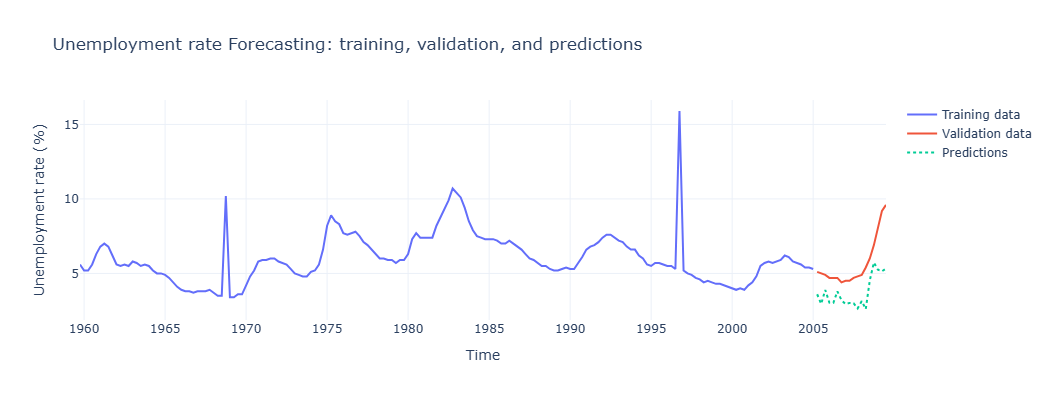

In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_ml.index, y=train_ml['unemp'], 
                         mode='lines', name='Training data'))
fig.add_trace(go.Scatter(x=val_ml.index, y=val_ml['unemp'], 
                         mode='lines', name='Validation data'))
fig.add_trace(go.Scatter(x=val_ml.index, y=y_pred, 
                         mode='lines', name='Predictions', 
                         line=dict(dash='dot')))
fig.update_layout(
    title='Unemployment rate Forecasting: training, validation, and predictions',
    xaxis_title='Time',
    yaxis_title='Unemployment rate (%)',
    template='plotly_white',
    width=1200,
    height=400
)
fig.show()


As we can see, the predictions for the LR model are not very well aligned with the actual values, since it is a benchmark model, the scope is to improve for the next models those predictions. I will now create the predictions for the period 2009q4 - 2013q4 and display them together with actual data

#### 2. Building the statistical models: SARIMAX and VARMAX

a) SARIMAX

SARIMAX is a suitable model for forecasting the unemployment rate because it directly models time-dependent patterns such as trends and cycles. . Since the unemployment rate is non-stationary, SARIMAX uses differencing (d=1) to stabilize the series before modeling. Additionally, we selected (p=1, q=1) based on ACF and PACF analysis, ensuring the model reflects the observed time dependencies.

For this step, we will focus on using the ACF and PACF plots in order to determine the order q using the autocorrelation function (ACF) and the order p through the partial autocorrelation function (PACF)

In [26]:
X_train_stat = train_stat.drop(columns=['unemp_wins_diff'])
y_train_stat = train_stat['unemp_wins_diff']
X_val_stat = val_stat.drop(columns=['unemp_wins_diff'])
y_val_stat = val_stat['unemp_wins_diff']

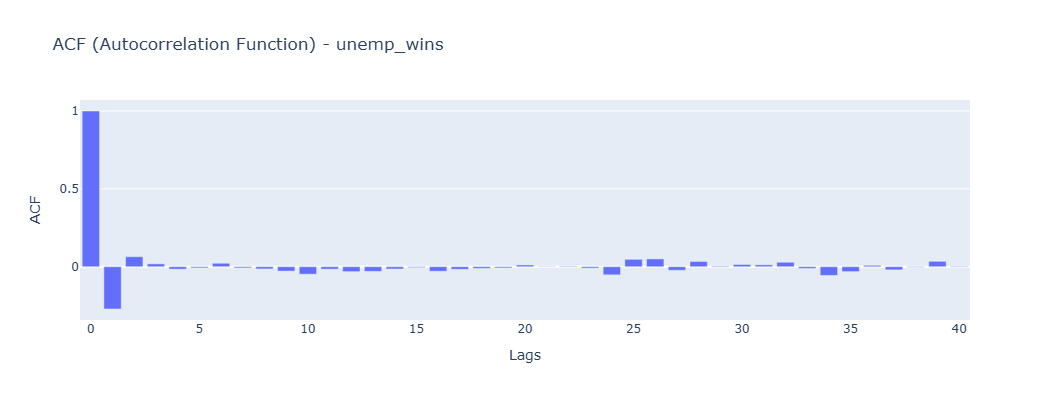

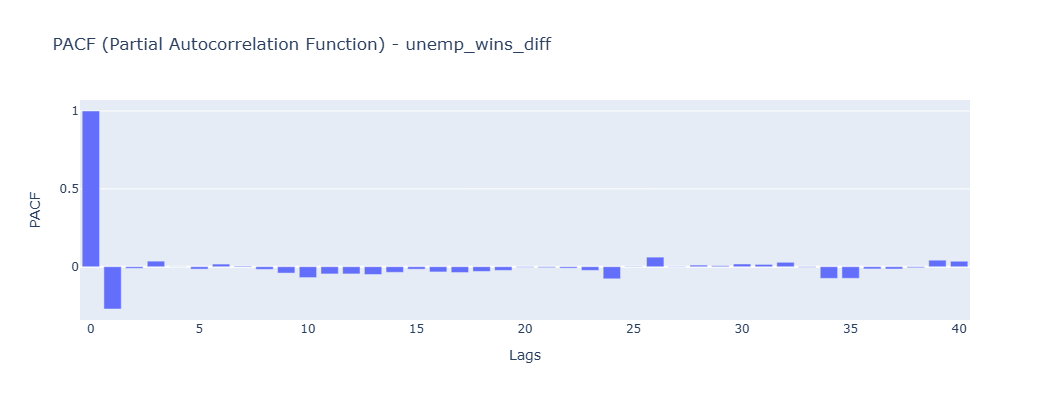

In [27]:
unemp_diff_series = stat_model_df['unemp_wins_diff']

acf_values = acf(unemp_diff_series, nlags=40)
pacf_values = pacf(unemp_diff_series, nlags=40, method='ywm')

acf_plot = go.Figure()
acf_plot.add_trace(go.Bar(x=list(range(len(acf_values))), y=acf_values, name='ACF'))
acf_plot.update_layout(
    title='ACF (Autocorrelation Function) - unemp_wins',
    xaxis_title='Lags',
    yaxis_title='ACF',
    width=700, height=400
)

pacf_plot = go.Figure()
pacf_plot.add_trace(go.Bar(x=list(range(len(pacf_values))), y=pacf_values, name='PACF'))
pacf_plot.update_layout(
    title='PACF (Partial Autocorrelation Function) - unemp_wins_diff',
    xaxis_title='Lags',
    yaxis_title='PACF',
    width=700, height=400
)

# Show plots
acf_plot.show()
pacf_plot.show()

Based on the cuttofs from the two plots, I will use q = 1 and p = 1 for the two orders. Also, the seasonal_order parameter is not necessary, based on the ACF, so there is no clear repeating pattern at regular intervals. I will set the order of differenciation to 1 (d = 1) because I've manually stationarized the unemp_wins variable

In [28]:
sarimax_model = sm.tsa.SARIMAX(
    y_train_stat, 
    exog=X_train_stat, 
    order=(1, 0, 1), 
    enforce_stationarity=False, 
    enforce_invertibility=False
)
sarimax_result = sarimax_model.fit(disp=False)

sarimax_forecast = sarimax_result.forecast(
    steps=len(y_val_stat), 
    exog=X_val_stat
)

mae = mean_absolute_error(y_val_stat, sarimax_forecast)
mse = mean_squared_error(y_val_stat, sarimax_forecast)
rmse = np.sqrt(mse)

sarimax_performance = pd.DataFrame({
    'Model': ['SARIMAX(1, 0, 1)'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse]
})

In [29]:
sarimax_performance

,Model,MAE,MSE,RMSE
0,"SARIMAX(1, 0, 1)",0.268592,0.123494,0.351417


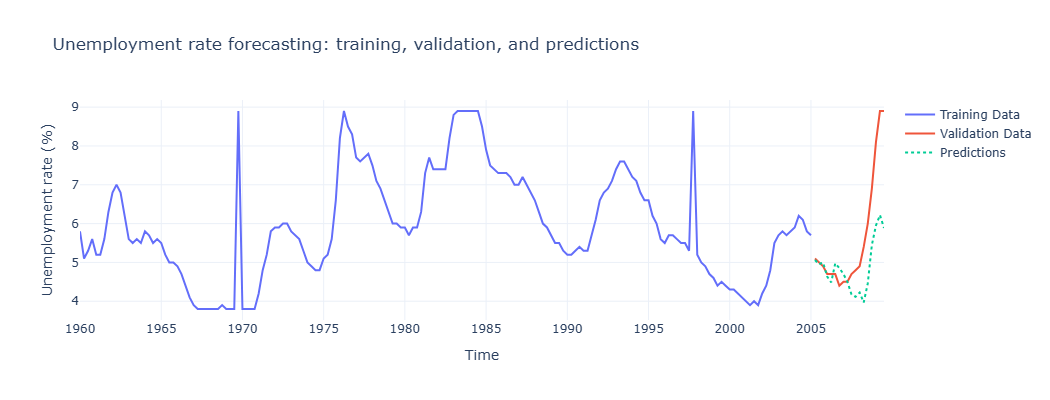

In [30]:
last_unemp_value = y_train_orig.iloc[-1]
sarimax_pred_original = last_unemp_value + sarimax_forecast.cumsum()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_stat.index, y=data_train['unemp_wins'], 
                         mode='lines', name='Training Data'))

fig.add_trace(go.Scatter(x=val_stat.index, y=data_val['unemp_wins'], 
                         mode='lines', name='Validation Data'))

fig.add_trace(go.Scatter(x=val_stat.index, y=sarimax_pred_original, 
                         mode='lines', name='Predictions', 
                         line=dict(dash='dot')))
fig.update_layout(
    title='Unemployment rate forecasting: training, validation, and predictions',
    xaxis_title='Time',
    yaxis_title='Unemployment rate (%)',
    template='plotly_white',
    width=1200,
    height=400
)

fig.show()


Is clear that the SARIMAX model performed better than the LR benchmark I'm using to compare the results (all 3 indicators improved)

b) Choosing another statistical model. Johansen cointegration test

Variable 'pop_diff_lag_1' introduces some problems inside our data, making the computational matrix inside the Johansen cointegration test not positive definite. So I chose a subset of this data in order to perform the cointegration test.

In [31]:
johansen_test = coint_johansen(stat_model_df[['unemp_wins_diff', 'infl', 'pop_diff', 'realgdp_diff', 'infl_rolling_mean_diff']], det_order=0, k_ar_diff=1)

johansen_results = pd.DataFrame({
    'Eigenvalue': johansen_test.eig,
    'Trace Statistic': johansen_test.lr1,
    'Critical Value (90%)': johansen_test.cvt[:, 0],
    'Critical Value (95%)': johansen_test.cvt[:, 1],
    'Critical Value (99%)': johansen_test.cvt[:, 2],
    'Max-Eigen Statistic': johansen_test.lr2,
    'Max-Eigen Critical Value (95%)': johansen_test.cvm[:, 1]
})

In [32]:
johansen_results

,Eigenvalue,Trace Statistic,Critical Value (90%),Critical Value (95%),Critical Value (99%),Max-Eigen Statistic,Max-Eigen Critical Value (95%)
0,0.867040,649.879368,65.8202,69.8189,77.8202,397.487910,33.8777
1,0.486617,252.391457,44.4929,47.8545,54.6815,131.346526,27.5858
2,0.295059,121.044932,27.0669,29.7961,35.4628,68.879279,21.1314
3,0.195461,52.165653,13.4294,15.4943,19.9349,42.844811,14.2639
4,0.046212,9.320841,2.7055,3.8415,6.6349,9.320841,3.8415


The hypotheses of the  Johansen cointegration test are defined as follows:
- H0: there are at most r cointegrating relationships
- H1: there are more than r cointegrating relationships

using both the trasce statistic and the max-eigen statistic , and comparing them with all the critical values accordingly, the conclusion is that there are 4 cointegrating relationship at the 95% confidence level. This means that the variables share a long-term equilibrium relationship despite short-term fluctuations. Based on this conclusion, I will use a Vector Error Correction Model (VECM) model to forecast on our validation data. 

In [33]:
stat_model_df_subset = stat_model_df[['unemp_wins_diff', 'infl', 'pop_diff', 'realgdp_diff', 'infl_rolling_mean_diff']].copy()

train_stat_subset = stat_model_df_subset.loc[train_start:train_end]
val_stat_subset = stat_model_df_subset.loc[val_start:val_end]
X_train_vecm = train_stat_subset.drop(columns=['unemp_wins_diff'])
y_train_vecm = train_stat_subset['unemp_wins_diff']
X_val_vecm = val_stat_subset.drop(columns=['unemp_wins_diff'])
y_val_vecm = val_stat_subset['unemp_wins_diff']

In [34]:
train_vecm = pd.concat([y_train_vecm, X_train_vecm], axis=1)
val_vecm = pd.concat([y_val_vecm, X_val_vecm], axis=1)

For the VECM model, I will choose the parameter k_ar_diff = 1 since I already have the variables differenced, so the short-term dynamics can be properly captured through a single lag in the data avoiding overfitting. Also, based on the Johansen cointegration test, the coint_rank will be set to 4.

In [35]:
vecm_model = VECM(train_vecm, k_ar_diff=1, coint_rank=4)
vecm_result = vecm_model.fit()

forecast_steps = len(val_vecm)
vecm_forecast = vecm_result.predict(steps=forecast_steps)

vecm_forecast_df = pd.DataFrame(
    vecm_forecast, 
    columns=train_vecm.columns, 
    index=val_vecm.index
)

mae = mean_absolute_error(y_val_vecm, vecm_forecast_df['unemp_wins_diff'])
mse = mean_squared_error(y_val_vecm, vecm_forecast_df['unemp_wins_diff'])
rmse = np.sqrt(mse)

# Display results
vecm_performance = pd.DataFrame({
    'Model': ['VECM'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse]
})

In [36]:
vecm_performance

,Model,MAE,MSE,RMSE
0,VECM,0.308663,0.205292,0.453092


As we can see, the VECM performs better than the benchmark LR, but it is behind the SARIMAX model based on the indicators we have calculated

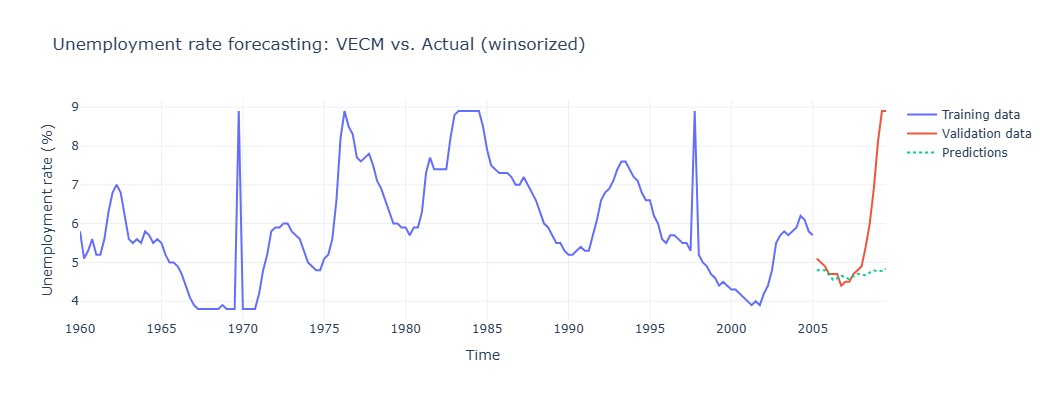

In [37]:
last_unemp_value = y_train_orig.iloc[-1]
vecm_unemp_forecast = last_unemp_value + vecm_forecast_df['unemp_wins_diff'].cumsum()

fig = go.Figure()

fig.add_trace(go.Scatter(x=train_stat.index, y=data_train['unemp_wins'], 
                         mode='lines', name='Training data'))

fig.add_trace(go.Scatter(x=val_stat.index, y=data_val['unemp_wins'], 
                         mode='lines', name='Validation data'))

fig.add_trace(go.Scatter(x=val_stat.index, y=vecm_unemp_forecast, 
                         mode='lines', name='Predictions', 
                         line=dict(dash='dot')))

fig.update_layout(
    title='Unemployment rate forecasting: VECM vs. Actual (winsorized)',
    xaxis_title='Time',
    yaxis_title='Unemployment rate (%)',
    template='plotly_white',
    width=1200,
    height=400
)

fig.show()

In [38]:
final_stat_df = pd.concat([benchmark_results, sarimax_performance, vecm_performance], ignore_index=True)
final_stat_df.sort_values(by='RMSE')

,Model,MAE,MSE,RMSE
1,"SARIMAX(1, 0, 1)",0.268592,0.123494,0.351417
2,VECM,0.308663,0.205292,0.453092
0,Linear regression (Benchmark),1.956603,4.697423,2.167354


For the OOS data I will use an ARIMA model (tuned for each time series) to create the missing data for the quarters needed to forecast in future. I will use the original data (taking into account the fact that not all variables are stationary) then proceed with the predictions using the SARIMAX model (being the best at trainig-test time). This OOS dataset will be used also for the ML models

In [39]:
oos_dates = pd.date_range(start='2009Q4', periods=17, freq='Q')
forecast_steps = len(oos_dates)

def find_best_arima_order(series, max_p=4, max_q=4, d = 0):
    best_aic = np.inf
    best_order = None
    for p in range(max_p+1):
        for q in range(max_q+1):
            try:
                model = ARIMA(series, order=(p, d, q))
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
            except:
                continue
    return best_order

def forecast_arima(series, steps, d):
    order = find_best_arima_order(series, d = d)
    model = ARIMA(series, order=order)
    result = model.fit()
    forecast = result.forecast(steps=steps)
    return forecast

infl_forecast = forecast_arima(data['infl'], forecast_steps, d = 0)
pop_forecast = forecast_arima(data['pop'], forecast_steps, d = 2)
realgdp_forecast = forecast_arima(data['realgdp'], forecast_steps, d = 1)

X_oos_stat = pd.DataFrame({
    'infl': infl_forecast,
    'pop': pop_forecast,
    'realgdp': realgdp_forecast,
})

In [40]:
X_oos_stat = pd.concat([data[['infl', 'realgdp', 'pop']], X_oos_stat])
general_df = pd.concat([data[['infl', 'realgdp', 'pop']], X_oos_stat])

In [41]:
for col in ['pop', 'realgdp']:
    X_oos_stat[col + '_diff'] = make_stationary(X_oos_stat[col])

Order 0: ADF statistic=1.6573072994825266, p-value=0.9980197126495454
Order 1: ADF statistic=-1.6856382395720129, p-value=0.43852686430062193
Order 2: ADF statistic=-4.603428001012049, p-value=0.0001273033895681538
Series is stationary after 2 diffs
Order 0: ADF statistic=0.8338025645073387, p-value=0.9921626679388044
Order 1: ADF statistic=-6.58141625743653, p-value=7.497798441990038e-09
Series is stationary after 1 diffs


In [42]:
X_oos_stat['infl_rolling_mean'] = X_oos_stat['infl'].rolling(window=4).mean()
X_oos_stat['pop_diff_lag_1'] = X_oos_stat['pop_diff'].shift(1)

In [43]:
X_oos_stat[-17:].drop(['pop_diff','realgdp_diff'], axis = 1).to_csv('X_future_ml.csv') # I saved this dataset for having the future data for the next predictions

In [44]:
X_oos_stat.dropna(inplace=True)
X_oos_stat['infl_rolling_mean_diff'] = make_stationary(X_oos_stat['infl_rolling_mean'])

Order 0: ADF statistic=-1.865126509580742, p-value=0.3486402650305513
Order 1: ADF statistic=-6.601227218913808, p-value=6.728005711362828e-09
Series is stationary after 1 diffs


In [45]:
X_oos_stat = X_oos_stat[-17:][['infl', 'pop_diff', 'realgdp_diff', 'pop_diff_lag_1', 'infl_rolling_mean_diff']].copy()

Now I will build the SARIMAX model using all the data available, then perform the forecasting on the OOS data I created before

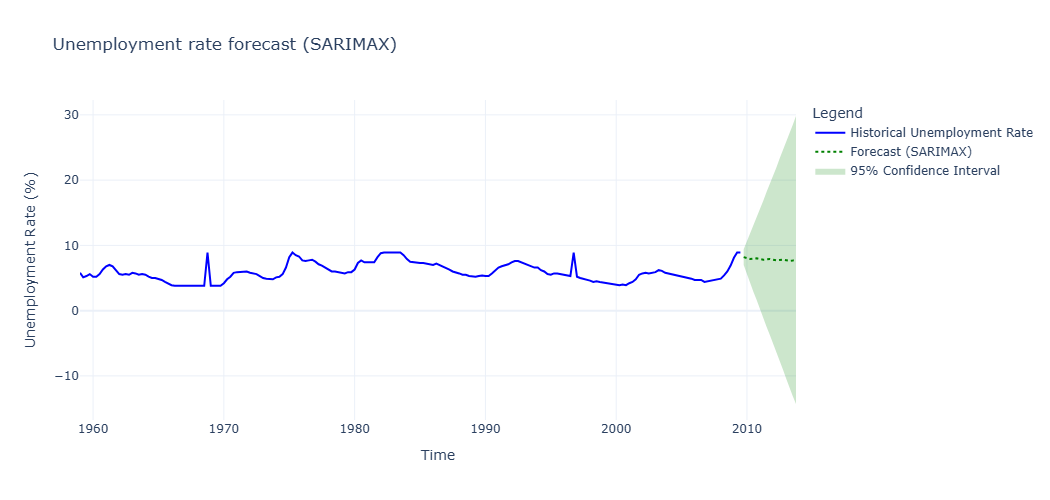

In [46]:

sarimax_model = sm.tsa.SARIMAX(
    pd.concat([y_train_stat, y_val_stat]), 
    exog=pd.concat([X_train_stat, X_val_stat]), 
    order=(1, 0, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_result = sarimax_model.fit(disp=False)

forecast_result = sarimax_result.get_forecast(
    steps=len(X_oos_stat),
    exog=X_oos_stat
)

forecast_diff = forecast_result.predicted_mean
forecast_conf_int = forecast_result.conf_int(alpha=0.05)

last_unemp_value = data['unemp_wins'].iloc[-1]

forecast_unemp = last_unemp_value + forecast_diff.cumsum()
forecast_lower = last_unemp_value + forecast_conf_int.iloc[:, 0].cumsum()
forecast_upper = last_unemp_value + forecast_conf_int.iloc[:, 1].cumsum()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['unemp_wins'],
    mode='lines',
    name='Historical Unemployment Rate',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=forecast_unemp.index,
    y=forecast_unemp,
    mode='lines',
    name='Forecast (SARIMAX)',
    line=dict(color='green', dash='dot')
))

fig.add_trace(go.Scatter(
    x=list(forecast_lower.index) + list(forecast_upper.index[::-1]),
    y=list(forecast_lower) + list(forecast_upper[::-1]),
    fill='toself',
    fillcolor='rgba(0,128,0,0.2)',
    line_color='rgba(255,255,255,0)',
    name='95% Confidence Interval'
))

fig.update_layout(
    title="Unemployment rate forecast (SARIMAX)",
    xaxis_title="Time",
    yaxis_title="Unemployment Rate (%)",
    legend_title="Legend",
    template="plotly_white",
    width=900,
    height=500
)

fig.show()

In [47]:
unemp_2013 = forecast_unemp.iloc[-4:]
pop_df = general_df['pop'].iloc[-4:]
pop_forecast_df = pd.concat([unemp_2013, pop_df], axis = 1)

In [48]:
pop_forecast_df

,predicted_mean,pop
2013-01-01,7.720604,317.587459
2013-04-01,7.624002,318.284213
2013-07-01,7.685600,319.068720
2013-10-01,7.759065,319.749127


In [49]:
pop_forecast_df['labor'] = pop_forecast_df['pop'] * 0.65
pop_forecast_df['unemployed'] = (pop_forecast_df['predicted_mean'] / 100) * pop_forecast_df['labor']
pop_forecast_df

,predicted_mean,pop,labor,unemployed
2013-01-01,7.720604,317.587459,206.431848,15.937786
2013-04-01,7.624002,318.284213,206.884738,15.772898
2013-07-01,7.685600,319.068720,207.394668,15.939525
2013-10-01,7.759065,319.749127,207.836933,16.126202


In [50]:
total_unemployed_2013 = pop_forecast_df['unemployed'].mean()
np.round(total_unemployed_2013, 2)

15.94

Based on our forecasting using the SARIMAX model for the unemp rate, approximately 15.94 million people (on average) are expected to be unemployed through 2013. 

I will follow the same process for the VECM model

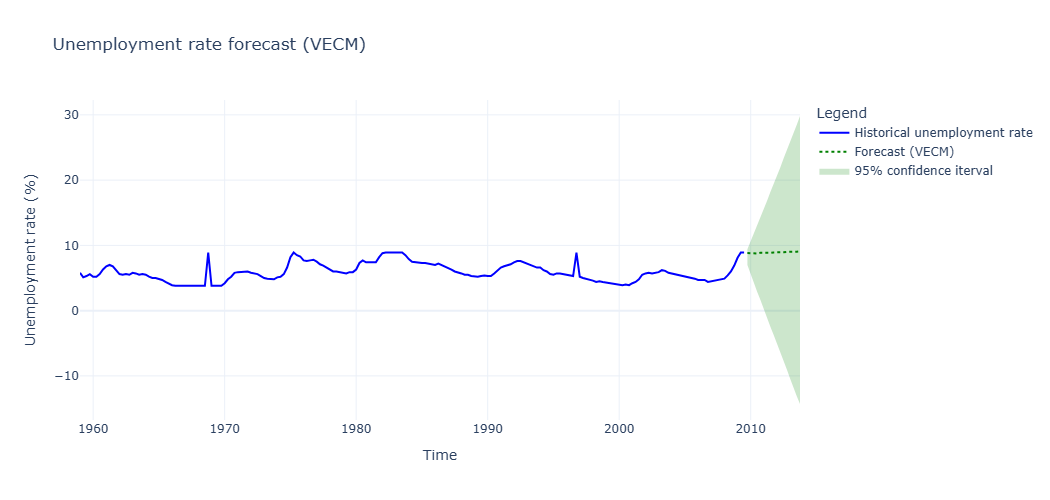

In [51]:
full_train_vecm = pd.concat([train_vecm, val_vecm])
vecm_model = VECM(full_train_vecm, k_ar_diff=1, coint_rank=4)
vecm_result = vecm_model.fit()

X_oos_vecm = X_oos_stat.drop('pop_diff_lag_1', axis = 1)
forecast_steps = len(X_oos_vecm)
vecm_forecast = vecm_result.predict(steps=forecast_steps)

vecm_forecast_df = pd.DataFrame(
    vecm_forecast,
    columns=full_train_vecm.columns,
    index=X_oos_vecm.index
)

last_unemp_value = data['unemp_wins'].iloc[-1]
forecast_unemp_vecm = last_unemp_value + vecm_forecast_df['unemp_wins_diff'].cumsum()

np.random.seed(42)
bootstrap_samples = np.array([
    vecm_forecast_df['unemp_wins_diff'] + np.random.normal(
        0, 
        np.sqrt(vecm_result.sigma_u[0, 0]), 
        len(vecm_forecast_df)
    )
    for _ in range(100)
])

lower_bound = last_unemp_value + np.percentile(bootstrap_samples, 2.5, axis=0).cumsum()
upper_bound = last_unemp_value + np.percentile(bootstrap_samples, 97.5, axis=0).cumsum()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['unemp_wins'],
    mode='lines',
    name='Historical unemployment rate',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=forecast_unemp_vecm.index,
    y=forecast_unemp_vecm,
    mode='lines',
    name='Forecast (VECM)',
    line=dict(color='green', dash='dot')
))

fig.add_trace(go.Scatter(
    x=list(forecast_lower.index) + list(forecast_upper.index[::-1]),
    y=list(forecast_lower) + list(forecast_upper[::-1]),
    fill='toself',
    fillcolor='rgba(0,128,0,0.2)',
    line_color='rgba(255,255,255,0)',
    name='95% confidence iterval'
))

fig.update_layout(
    title="Unemployment rate forecast (VECM)",
    xaxis_title="Time",
    yaxis_title="Unemployment rate (%)",
    legend_title="Legend",
    template="plotly_white",
    width=1200,
    height=500
)

In [52]:
unemp_2013_vecm = forecast_unemp_vecm.iloc[-4:]
pop_df = general_df['pop'].iloc[-4:]
pop_forecast_df_vecm = pd.concat([unemp_2013_vecm, pop_df], axis = 1)
pop_forecast_df_vecm

,unemp_wins_diff,pop
2013-01-01,8.982569,317.587459
2013-04-01,8.978300,318.284213
2013-07-01,9.031672,319.068720
2013-10-01,9.072512,319.749127


In [53]:
pop_forecast_df_vecm['labor'] = pop_forecast_df_vecm['pop'] * 0.65
pop_forecast_df_vecm['unemployed'] = (pop_forecast_df_vecm['unemp_wins_diff'] / 100) * pop_forecast_df_vecm['labor']
pop_forecast_df_vecm

,unemp_wins_diff,pop,labor,unemployed
2013-01-01,8.982569,317.587459,206.431848,18.542883
2013-04-01,8.978300,318.284213,206.884738,18.574732
2013-07-01,9.031672,319.068720,207.394668,18.731206
2013-10-01,9.072512,319.749127,207.836933,18.856031


In [54]:
total_unemployed_2013_vecm = pop_forecast_df_vecm['unemployed'].mean()
np.round(total_unemployed_2013_vecm, 2)

18.68

Based on our forecasting using the VECM model for the unemp rate, approximately 18.68 million people (on average) are expected to be unemployed through 2013. It seems that the VECM model uplifts the predictions, increasing the unemp rate in the OOS data, while the SARIMAX model slowly decreases it.

#### Ensemble model forecast. Combining the predictions from the two models available

In [55]:
ensemble_forecast = (forecast_unemp + forecast_unemp_vecm) / 2
ensemble_forecast

2009-10-01    8.517234
2010-01-01    8.402066
2010-04-01    8.315893
2010-07-01    8.360700
2010-10-01    8.443831
2011-01-01    8.364698
2011-04-01    8.293873
2011-07-01    8.347458
2011-10-01    8.419969
2012-01-01    8.352307
2012-04-01    8.291453
2012-07-01    8.350300
2012-10-01    8.412145
2013-01-01    8.351587
2013-04-01    8.301151
2013-07-01    8.358636
2013-10-01    8.415789
Freq: QS-OCT, dtype: float64

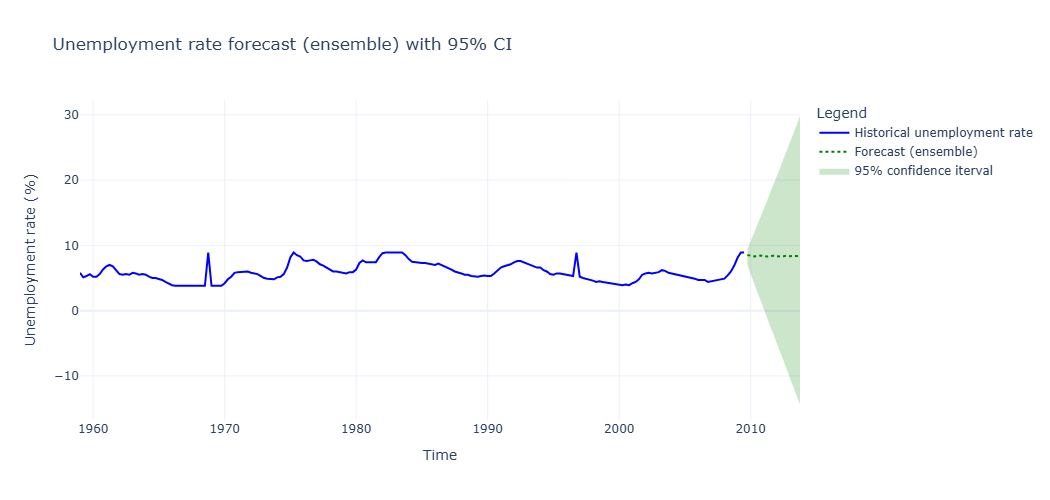

In [56]:
lower_bound = last_unemp_value + np.percentile(bootstrap_samples, 2.5, axis=0).cumsum()
upper_bound = last_unemp_value + np.percentile(bootstrap_samples, 97.5, axis=0).cumsum()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['unemp_wins'],
    mode='lines',
    name='Historical unemployment rate',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=ensemble_forecast.index,
    y=ensemble_forecast,
    mode='lines',
    name='Forecast (ensemble)',
    line=dict(color='green', dash='dot')
))

fig.add_trace(go.Scatter(
    x=list(forecast_lower.index) + list(forecast_upper.index[::-1]),
    y=list(forecast_lower) + list(forecast_upper[::-1]),
    fill='toself',
    fillcolor='rgba(0,128,0,0.2)',
    line_color='rgba(255,255,255,0)',
    name='95% confidence iterval'
))

fig.update_layout(
    title="Unemployment rate forecast (ensemble) with 95% CI",
    xaxis_title="Time",
    yaxis_title="Unemployment rate (%)",
    legend_title="Legend",
    template="plotly_white",
    width=1200,
    height=500
)

Save the data for the ML approach in order to create a new notebook for this task

In [57]:
ml_model_df.to_csv('ml_model_df.csv')